### ok lets look beyond the bigram

now we look at a context length within names

for 'emma' before we had

* e -> m
* m -> m
* m -> a
* a -> .

this becomes

* ...e  -> m
* ..em  -> m
* .emm  -> a
* emma  -> .

so now we're considering how a sequence of letters generates the following letter

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [27]:
# our embedding space
context_length = 5
embedding_dimensions = 2
vocab_size = 27
es = torch.randn(vocab_size, embedding_dimensions)

In [22]:
# show the embedding space an the 'a' co-ordinates (Transpose es just to save display space)
es.shape, es[0,0], es[1]

(torch.Size([27, 2]), tensor(0.3949), tensor([0.5134, 1.6276]))

In [4]:
with open("names.txt", "r") as r:
    names = ["." + f + "." for f in r.read().split()]

import string
letters = [l for l in string.ascii_lowercase]

itos = {0: "."}
stoi = {".": 0}

for i, l in enumerate(letters):
    offset = i+1
    stoi[l] = offset
    itos[offset] = l


In [5]:
stoi['a'], len(names)

(1, 32033)

In [6]:
from random import randrange

names_length = len(names)

def sample_names(size=5):
    batch_names = []
    for i in range(size):
        ni = randrange(names_length-1)
        name = names[ni]
        batch_names.append(name)
    return batch_names

sample_names(2)

['.amariya.', '.seraphim.']

### the new part

now for our xs we take the name and break it into a number of windows of length 'context_lenght' = 4

In [7]:
def word_contexts(word):
    samples = []
    max_length = len(word)
    fill = '.' * context_length
    for i in range(1,max_length):
        st = max(0, i-context_length)
        filled = fill[i:] + word[st:i]
        samples.append(filled[:context_length])
    return samples
word_contexts(".timothy.")

['.....', '....t', '...ti', '..tim', '.timo', 'timot', 'imoth', 'mothy']

In [19]:
def get_xys(samples):
    xs, ys = [], []
    for s in samples:
        for ctx in word_contexts(s):
            x =  [stoi[c] for c in ctx]
            xs.append(x)
        y = [stoi[c] for c in s[1:]]
        ys += y

    return xs, ys

In [9]:
x, y = get_xys(sample_names(2))
print(y)
X, Y = torch.tensor(x), torch.tensor(y)
X.shape, X, Y.shape

[8, 15, 23, 1, 18, 4, 0, 11, 1, 4, 9, 19, 15, 14, 0]


(torch.Size([15, 5]),
 tensor([[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  8],
         [ 0,  0,  0,  8, 15],
         [ 0,  0,  8, 15, 23],
         [ 0,  8, 15, 23,  1],
         [ 8, 15, 23,  1, 18],
         [15, 23,  1, 18,  4],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 11],
         [ 0,  0,  0, 11,  1],
         [ 0,  0, 11,  1,  4],
         [ 0, 11,  1,  4,  9],
         [11,  1,  4,  9, 19],
         [ 1,  4,  9, 19, 15],
         [ 4,  9, 19, 15, 14]]),
 torch.Size([15]))

## OK lets run this and see what happens...

In [35]:
es = torch.randn((vocab_size, embedding_dimensions), requires_grad=True)
W1 = torch.randn((embedding_dimensions*context_length, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [es, W1, b1, W2, b2]

In [36]:
names_length = len(names)
epochs = 120
batch_size = 800
learning_rate = .2
samples = 1000 #in future we want our epoch to roughly sample everything - names_length / batch_size

In [38]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = get_xys(sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        # print("linear input", l_in)
        outputL1 = torch.relu(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2
        # print("cross_entropy input", logits.shape, Y.shape)
        
        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    print(epoch_loss/samples)
    learning_rate *= .98
    # print(ep, learning_rate)

tensor(2.4213, grad_fn=<DivBackward0>)
tensor(2.4109, grad_fn=<DivBackward0>)


In [19]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = [0, 0, 0, 0, 0]
        for nl in range(10):
            xenc = es[ix]

            outputL1 = torch.relu(xenc.view(-1, 2 * context_length) @ W1 + b1)
            logits = outputL1 @ W2 + b2
            
            p = F.softmax(logits, dim=1)
    
            # ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            # ## (p is normalized in the softmax above)
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(itos[prediction])
            
        print("".join(out))

generate_names(1)

jcalu


In [20]:
generate_names(15)

ylyuj
eraa
kmanua
ckillee
rdvayno
kemr
kouiaads
adina
kmimasg
kabvela
zradst
jmaaade
kmawoe
kbaaa
meeassna


## Better everything

our names are definitely better also maybe more interesting are plots of our embedding space

below are plots from separate runs with randomly generated parameters

all the plots group a, e, i, o, u and y...

. (dot) is an outlier

the constants are interesting too

c, p, g, s, b, t cluster 

k, d cluster etc...

so we're both making better words and discovering some underlying order

for some reason n and h seem pulled towards the vowels too

In [21]:
import matplotlib.pyplot as plt

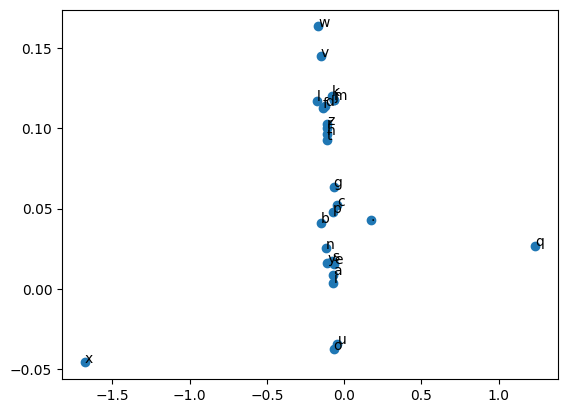

In [22]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

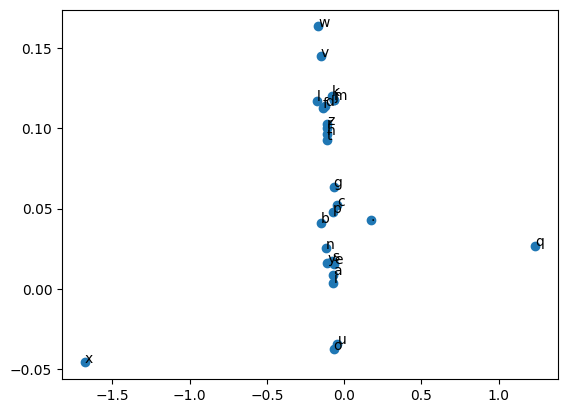

In [23]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

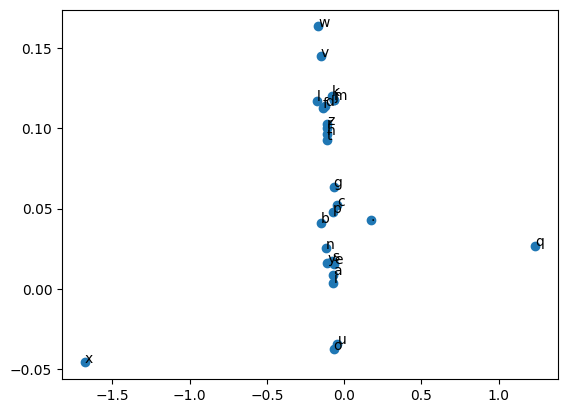

In [24]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

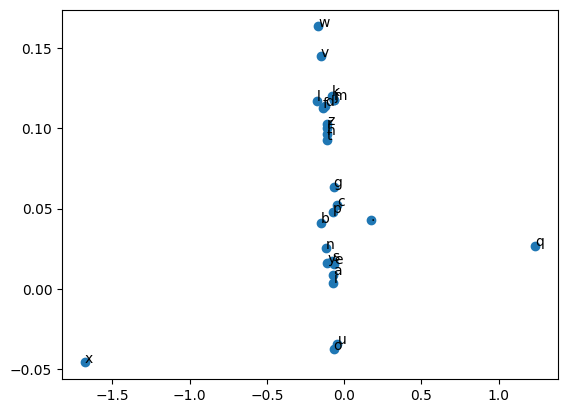

In [25]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

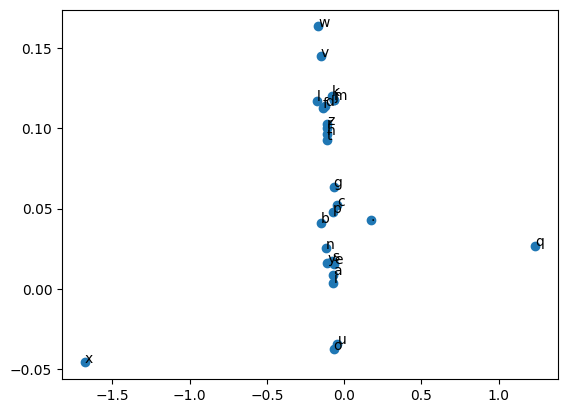

In [26]:
x = es.T[0].tolist()
y = es.T[1].tolist()
n = ['.'] + letters

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [27]:
m = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = m(input)
output.shape

torch.Size([20, 100, 35, 45])